In [209]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

In [210]:
# 데이터 전처리
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Resize((50, 50))
])

In [237]:
# 데이터셋 로드
img_root = 'data'
dataset = ImageFolder(root=img_root, transform=transform)
for i in dataset.classes:
    print(f'"{i}', end='\",')

"ev6","ev9","qm3","qm6","sm3","sm6","test","xm3","그랜저","넥쏘","더 뉴 아반떼","렉스턴","스타리아","싼타페","쏘나타","아우디 a4","아우디 a5","아우디 a6","아우디 a7","아우디 e-tron","아우디 q3","아우디 q7","아우디 q8","아이오닉5","아이오닉6","제네시스 g70","제네시스 g90","제네시스 gv70","코나","코란도","토레스","투싼",

In [212]:
# 데이터셋 분할 (학습/검증/테스트)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


# 하이퍼파라미터 설정
batch_size = 32
num_epochs = 30
learning_rate = 0.001

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [213]:
import torch.nn.functional as F


# CNN 모델 정의
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 12 * 12, 64)
        self.fc2 = nn.Linear(64, 31)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [214]:
# 모델 인스턴스 생성
model = CNNModel()

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 옵티마이저 정의
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 리스트 정의
trainList = []
valList = []
testList = []

In [215]:
# 학습 함수
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        trainList.append(loss)
    return running_loss / len(loader)

In [216]:
# 검증 함수
def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            valList.append(loss)
    return running_loss / len(loader)

In [218]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
SCHEDULERS = ReduceLROnPlateau(optimizer, mode = 'min', patience = 3, verbose = True)
cnt = 0

# 학습 루프
best_val_loss = 10000
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss = validate(model, val_loader, criterion)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    if SCHEDULERS.num_bad_epochs >= SCHEDULERS.patience:
        print(f"Early stopping at epoch {epoch}")
        break
    # print(epoch)

Epoch 1/30, Train Loss: 2.3727, Val Loss: 2.0061
Epoch 2/30, Train Loss: 1.5511, Val Loss: 1.4101
Epoch 3/30, Train Loss: 1.1014, Val Loss: 1.0586
Epoch 4/30, Train Loss: 0.7821, Val Loss: 0.7958
Epoch 5/30, Train Loss: 0.6214, Val Loss: 0.8891
Epoch 6/30, Train Loss: 0.5868, Val Loss: 0.7018
Epoch 7/30, Train Loss: 0.5320, Val Loss: 0.6280
Epoch 8/30, Train Loss: 0.3585, Val Loss: 0.3979
Epoch 9/30, Train Loss: 0.2235, Val Loss: 0.3466
Epoch 10/30, Train Loss: 0.1678, Val Loss: 0.3192
Epoch 11/30, Train Loss: 0.1334, Val Loss: 0.2597
Epoch 12/30, Train Loss: 0.1153, Val Loss: 0.2878
Epoch 13/30, Train Loss: 0.1191, Val Loss: 0.3095
Epoch 14/30, Train Loss: 0.0868, Val Loss: 0.2404
Epoch 15/30, Train Loss: 0.0885, Val Loss: 0.2079
Epoch 16/30, Train Loss: 0.0672, Val Loss: 0.2536
Epoch 17/30, Train Loss: 0.1521, Val Loss: 0.2916
Epoch 18/30, Train Loss: 0.0664, Val Loss: 0.2112
Epoch 19/30, Train Loss: 0.0418, Val Loss: 0.1857
Epoch 20/30, Train Loss: 0.0284, Val Loss: 0.1724
Epoch 21/

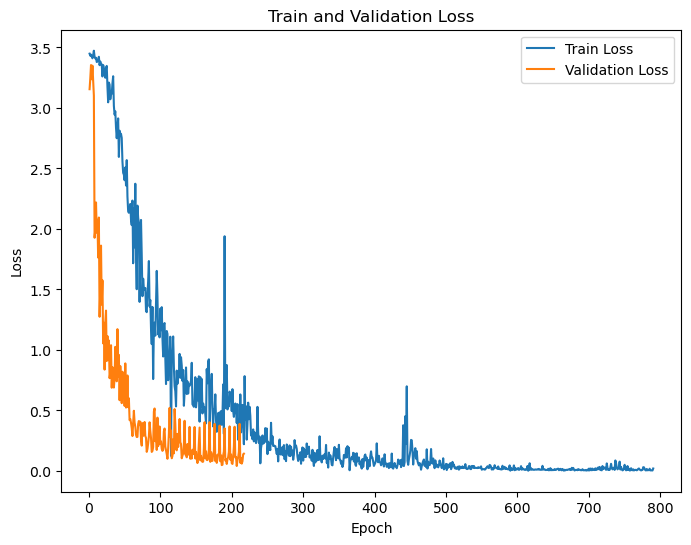

/Users/sml/anaconda3/envs/Torch_PY38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Test Accuracy: 96.40%


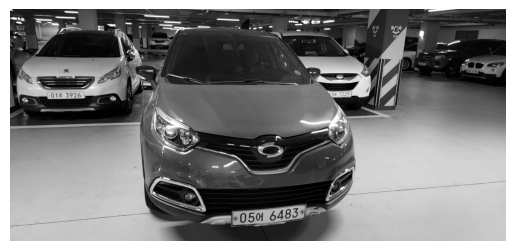

예측 클래스: 렉스턴
예측 확률: 100.00%


In [238]:
import matplotlib.pyplot as plt

# 에포크 loss 시각화
plt.figure(figsize=(8, 6))
x = range(1,len(trainList)+1)
plt.plot(x, torch.tensor(trainList).detach().numpy(), label='Train Loss')
x = range(1,len(valList)+1)
plt.plot(x, torch.tensor(valList).detach().numpy(), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# 테스트 함수
def test(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    testList.append(accuracy)
    return accuracy

# 모델 로드 및 테스트
model.load_state_dict(torch.load('best_model.pth'))
test_accuracy = test(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')


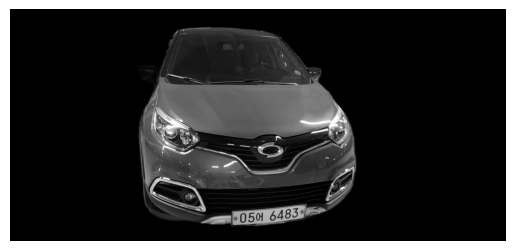

예측 클래스: ev9
예측 확률: 98.00%


In [242]:

# 테스트 결과 출력

img_path = 'test/image2.png'  # 테스트 이미지 경로

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 그레이스케일 변환
    transforms.ToTensor(),
    transforms.Resize((50, 50))
])

img = Image.open(img_path).convert('L')
img_tensor = transform(img).unsqueeze(0)

model.eval()

with torch.no_grad():
    output = model(img_tensor)
    _, predicted = torch.max(output.data, 1)

plt.imshow(img, cmap='gray')  # 그레이스케일 이미지로 표시
plt.axis('off')
plt.show()

# 결과 출력
prob = torch.softmax(output, dim=1).detach().squeeze().numpy()
max_prob = max(prob)
rounded_prob = round(max_prob, 2)

class_names = ["ev6","ev9","qm3","qm6","sm3","sm6","test","xm3","그랜저","넥쏘","더 뉴 아반떼","렉스턴","스타리아","싼타페","쏘나타","아우디 a4","아우디 a5","아우디 a6","아우디 a7","아우디 e-tron","아우디 q3","아우디 q7","아우디 q8","아이오닉5","아이오닉6","제네시스 g70","제네시스 g90","제네시스 gv70","코나","코란도","토레스","투싼"]  # 클래스 이름 리스트 (실제 클래스 이름으로 변경해야 함)
predicted_class = class_names[predicted.item()]

print(f"예측 클래스: {predicted_class}")
print(f"예측 확률: {rounded_prob*100:.2f}%")